<a href="https://colab.research.google.com/github/jinkim-com/qm2coursework/blob/main/NLP_Trump_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trump NLP

In [1]:
%%capture
!pip install spacy
!pip install scattertext
!pip install tika
!pip install spacytextblob
!pip install gensim
!pip install scikit-learn
!pip install torch
!pip install scipy
!python -m spacy download en_core_web_sm
!pip install contractions

import spacy
import json
import pylab
from IPython.core.display import display, HTML
import nltk
from tika import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob
import re
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from IPython.core.display import display, HTML

import string
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import string

# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



%matplotlib inline
pylab.rcParams['figure.figsize'] = (10., 8.)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
nltk.download('punkt_tab')


# Linking files and downloads from GitHub


In [2]:
url = "https://raw.githubusercontent.com/jinkim-com/qm2coursework/refs/heads/main/Trump_2020.csv"
df = pd.read_csv(url)

# Cleaning the Data

**Our data may still has some unwanted characters such as \n. This means we need to clean the data:**


In [3]:
# Removing all isntances of \n

df['Speech'] = df['Speech'].str.replace('\n', '', regex=False)

We also need to check that all the speeches are before the election (and are therefore part of the campaign). We can then remove unwanted speeches from the data.

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
cutoff_date = pd.to_datetime('2020-11-06')
df = df[df['Date'] <= cutoff_date]
df.head()

<ipython-input-4-ccf6c78fc02c>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Speech,Date
0,Thank you. Thank you. I love New Jersey and I’...,2020-01-28
1,I worked so hard for this state. I worked so ...,2020-01-30
2,"Hello, Manchester, and I am thrilled to be in ...",2020-10-02
3,"Thank you very much, Phoenix. We love to be b...",2020-02-20
4,"Well, thank you very much. And hello Las Vegas...",2020-02-21


# Using contexual embedding techniques to find the words associated with a main word

We are using a pre-trained model in order to find the words most associated with our voter issues. These words are then classified as the regular expressions (RegEx) that we are searching for within the speeches. Instead of using Word2Vec, we are using GloVe, which is more lightweight. This means it is faster and a smaller download which is good for GitHub, but nonetheless effective.

In [5]:
from gensim.downloader import load

# Load the GloVe model (100-dimensional)
glove_model = load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [6]:
# Size of the vocabulary
print(f"Vocabulary size: {len(glove_model.index_to_key)}")

# Dimension of word vectors
print(f"Vector size: {glove_model.vector_size}")


Vocabulary size: 400000
Vector size: 100


In [7]:
def format_results(results):
    return "\n".join([f"{i+1}. {word} (Similarity: {similarity:.4f})"
                      for i, (word, similarity) in enumerate(results)])

# Function to find top 10 similar words to a single word
def find_similar_single(word, topn=10):
    if word in glove_model:
        results = glove_model.most_similar(positive=[word], topn=topn)
        print(f"Top {topn} words similar to '{word}':\n" + format_results(results)+ "\n")
        return [word for word, _ in results]
    else:
        print(f"Word '{word}' not found in the model vocabulary.")

# Function to find top 10 similar words to a combination of two words
def find_similar_combination(word1, word2, topn=10):
    missing_words = [word for word in [word1, word2] if word not in glove_model]
    if missing_words:
        print(f"The following words are not in the vocabulary: {', '.join(missing_words)}")
        return [word for word, _ in results]

    results = glove_model.most_similar(positive=[word1, word2], topn=topn)
    print((f"Top {topn} words similar to the combination of '{word1}' + '{word2}':\n"
            + format_results(results))+"\n")
    return [word for word, _ in results]

In [8]:
economy_top10 = find_similar_single('economy')
healthcare_top10 = find_similar_single('healthcare')
crime_top10 = find_similar_single('crime')
foreign_policy_top10 = find_similar_combination('foreign', 'policy')
immigration_top10 = find_similar_single('immigration')

Top 10 words similar to 'economy':
1. economic (Similarity: 0.8279)
2. growth (Similarity: 0.7947)
3. recession (Similarity: 0.7692)
4. economies (Similarity: 0.7545)
5. recovery (Similarity: 0.7491)
6. downturn (Similarity: 0.7462)
7. slowdown (Similarity: 0.7368)
8. slowing (Similarity: 0.7281)
9. sector (Similarity: 0.7247)
10. crisis (Similarity: 0.7136)

Top 10 words similar to 'healthcare':
1. health (Similarity: 0.7659)
2. care (Similarity: 0.7575)
3. services (Similarity: 0.6494)
4. medicare (Similarity: 0.6475)
5. medical (Similarity: 0.6411)
6. insurance (Similarity: 0.6283)
7. education (Similarity: 0.6249)
8. provider (Similarity: 0.6174)
9. providers (Similarity: 0.6123)
10. medicaid (Similarity: 0.6097)

Top 10 words similar to 'crime':
1. criminal (Similarity: 0.7859)
2. crimes (Similarity: 0.7696)
3. murder (Similarity: 0.6961)
4. trafficking (Similarity: 0.6934)
5. terrorism (Similarity: 0.6890)
6. homicide (Similarity: 0.6839)
7. corruption (Similarity: 0.6802)
8. cri

# Finding the frequency of regular expressions affliated with voter issues

In [9]:
# We created a function that will take a list of words which are affliated with topics of voter importance and display a table of how many times they collectively occcur in each speech.

def count_words(dataset, words, title, text_column, source_title=None):
    """
    Analyses the frequency of specified words in a dataset and generates a summary with a graph.

    Parameters:
        dataset (pd.DataFrame): The dataset containing at least the text and date columns.
        words (list): A list of words to count in the text column.
        title (str): A title for the summary statistics and analysis.
        text_column (str): The name of the column containing the text to analyse.
        graph_title (str): Custom title for the graph. If None, a default title is used.
    """
    import re
    import pandas as pd
    import matplotlib.pyplot as plt

    if text_column not in dataset.columns:
        raise ValueError(f"The specified text column '{text_column}' does not exist in the dataset.")

    # Create a column showing the frequency of the words being used
    dataset[f'{words[0]}'] = dataset[text_column].apply(
        lambda x: sum(len(re.findall(r'\b' + word + r'\b', str(x), re.IGNORECASE)) for word in words)
    )
    capitalised_words = [word.capitalize() for word in words]

    # Summary statistics
    summary_stats = dataset[f'{words[0]}'].round(1).describe().T
    filtered_stats = summary_stats.drop(['count'])
    sum_of_words = dataset[f"{words[0]}"].sum()
    print(f"Total mentions of {title}: {sum_of_words}")
    print(filtered_stats)

    # Creating the graph
    if 'Date' not in dataset.columns:
        raise ValueError("The dataset must contain a 'Date' column.")

    dataset['Date'] = pd.to_datetime(dataset['Date'])  # Convert 'Date' column to datetime
    dataset['Month'] = dataset['Date'].dt.month
    monthly = dataset.groupby('Month')[f'{words[0]}'].sum()

    # Use custom graph title if provided, otherwise generate a default one
    graph_title = f"Frequency of {title} mentioned in {source_title} by month"

    monthly.plot()
    plt.xlabel("Month")
    plt.ylabel(f"No. of times {title} was mentioned")
    plt.title(graph_title)
    plt.show()

    return monthly


Total mentions of Economy: 94
mean     2.410256
std      2.711748
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     14.000000
Name: economic, dtype: float64


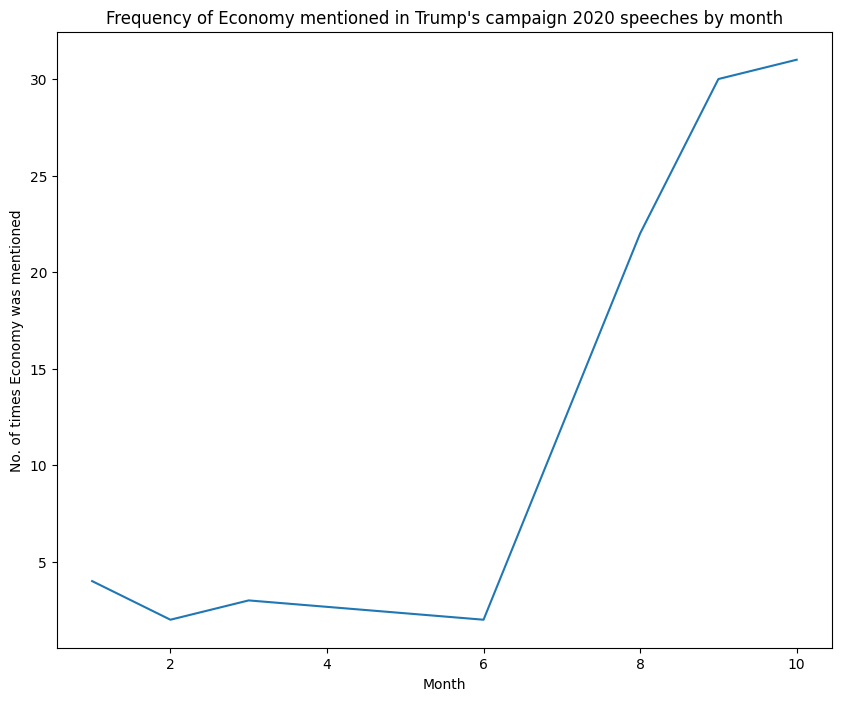

,economic
Month,
1,4
2,2
3,3
6,2
8,22
9,30
10,31


In [10]:
count_words(df, economy_top10, 'Economy', 'Speech', "Trump's campaign 2020 speeches")


Total mentions of Healthcare: 470
mean    12.051282
std      7.887194
min      1.000000
25%      8.000000
50%     10.000000
75%     15.000000
max     37.000000
Name: health, dtype: float64


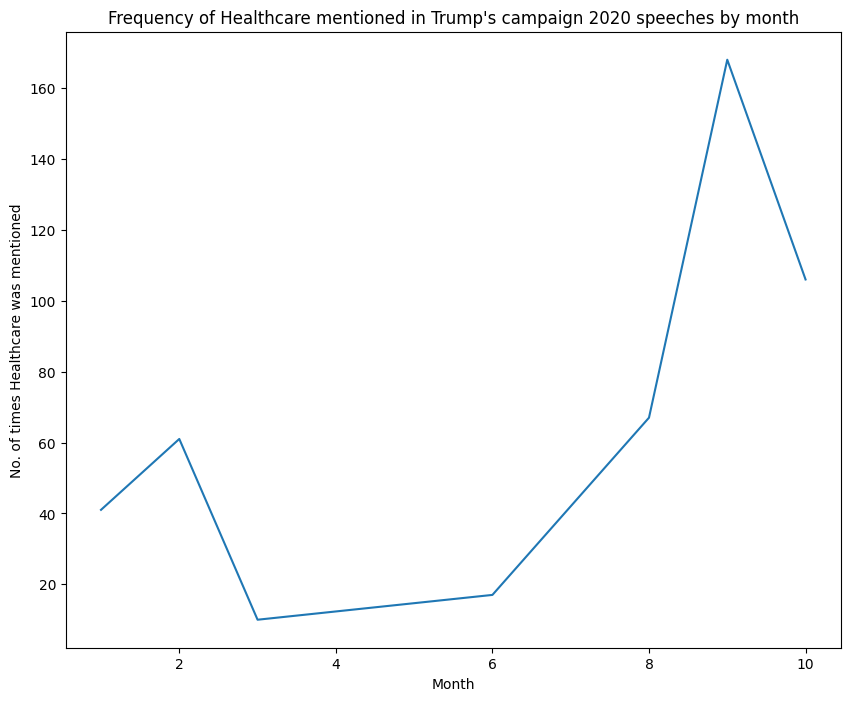

,health
Month,
1,41
2,61
3,10
6,17
8,67
9,168
10,106


In [11]:
count_words(df, healthcare_top10, 'Healthcare', 'Speech', "Trump's campaign 2020 speeches")

Total mentions of Crime: 277
mean     7.102564
std      4.369722
min      1.000000
25%      4.000000
50%      6.000000
75%      9.500000
max     16.000000
Name: criminal, dtype: float64


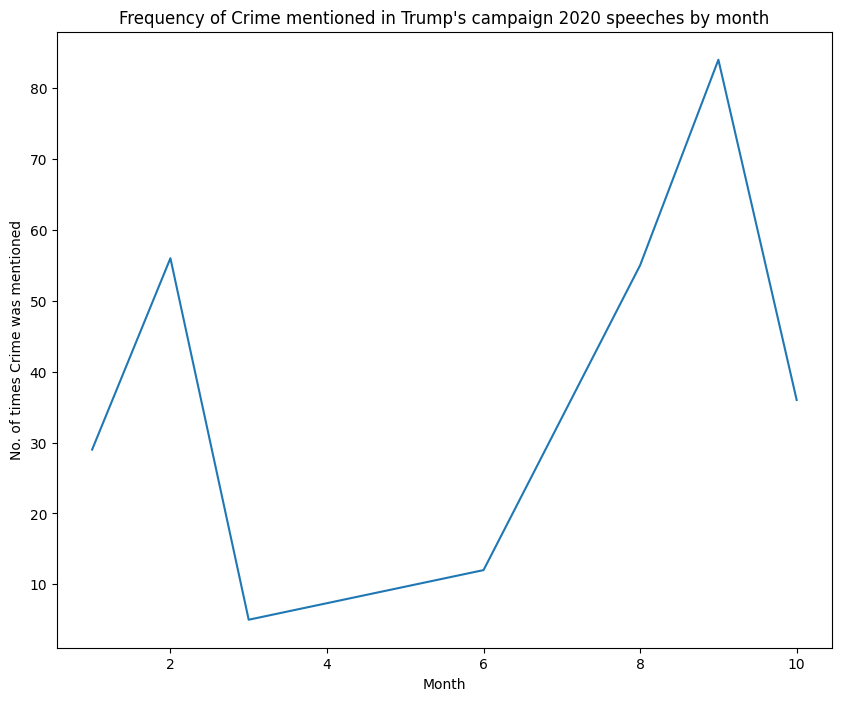

,criminal
Month,
1,29
2,56
3,5
6,12
8,55
9,84
10,36


In [12]:
count_words(df, crime_top10, 'Crime', 'Speech', "Trump's campaign 2020 speeches")

Total mentions of Foreign Policy: 560
mean    14.358974
std      6.076214
min      2.000000
25%     10.000000
50%     14.000000
75%     18.500000
max     29.000000
Name: policies, dtype: float64


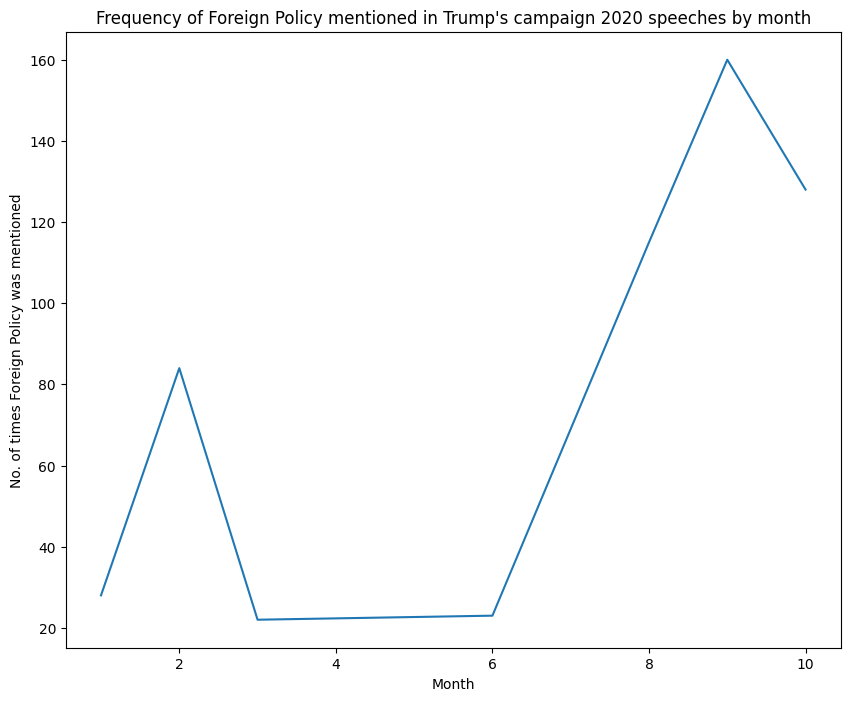

,policies
Month,
1,28
2,84
3,22
6,23
8,115
9,160
10,128


In [13]:
count_words(df, foreign_policy_top10, 'Foreign Policy', 'Speech', "Trump's campaign 2020 speeches")

Total mentions of Immigration: 732
mean    18.769231
std      8.170749
min      1.000000
25%     13.500000
50%     19.000000
75%     24.000000
max     36.000000
Name: immigrants, dtype: float64


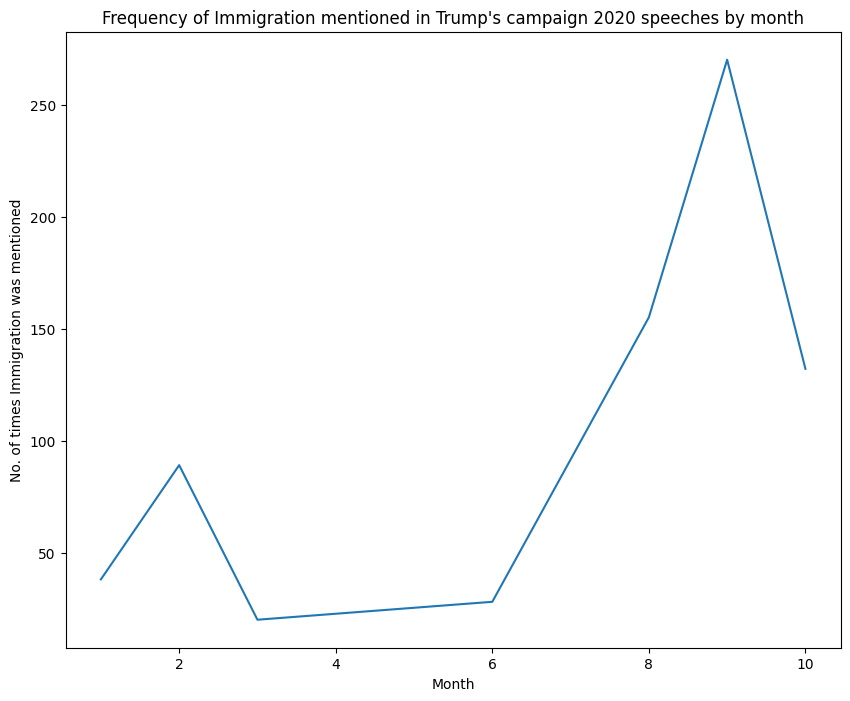

,immigrants
Month,
1,38
2,89
3,20
6,28
8,155
9,270
10,132


In [14]:
count_words(df, immigration_top10, 'Immigration', 'Speech', "Trump's campaign 2020 speeches")

# Sentiment Analysis

In [ ]:
if "spacytextblob" not in nlp.pipe_names:  # Check if component is already added
    nlp.add_pipe("spacytextblob")

def get_sentiment_scores_batch(texts):
    polarity_scores = []
    subjectivity_scores = []
    for text in texts:
        # Check if the text is valid before processing
        if text and isinstance(text, str):
            doc = nlp(text)  # Process individual texts
            polarity_scores.append(doc._.blob.polarity)
            subjectivity_scores.append(doc._.blob.subjectivity)
        else:
            # Append default values if text is invalid
            polarity_scores.append(np.nan)
            subjectivity_scores.append(np.nan)

    return polarity_scores

# Apply the function to the 'Speech' column and create new columns
df['Polarity']  = get_sentiment_scores_batch(df['Speech']) # Assign the results to both columns
df.head()




In [ ]:
summary_stats_pol = df['Polarity'].round(1).describe().T
filtered_stats = summary_stats_pol.drop(['count'])
print(f"Summary Statistics for Polarity Scores for Trump's 2020 Campaign Speeches: \n{filtered_stats}")

Summary Statistics for Polarity Scores for Trump's 2020 Campaign Speeches: 
mean    0.184615
std     0.043155
min     0.100000
25%     0.200000
50%     0.200000
75%     0.200000
max     0.300000
Name: Polarity, dtype: float64

Summary Statistics for Subjectivity Scores for Trump's 2020 Campaign Speeches: 
mean    0.5
std     0.0
min     0.5
25%     0.5
50%     0.5
75%     0.5
max     0.5
Name: Subjectivity, dtype: float64


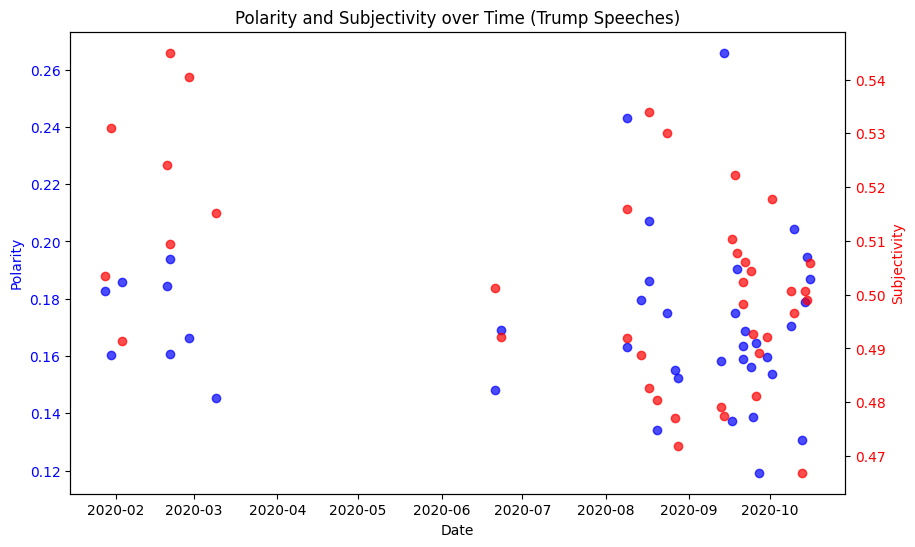

In [ ]:
# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for Polarity on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Polarity', color='blue')
ax1.scatter(df['Date'], df['Polarity'], color='blue', alpha=0.7)  # Scatter plot
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Add title
plt.title('Polarity over Time (Trump Speeches)')

# Display the plot
plt.show()

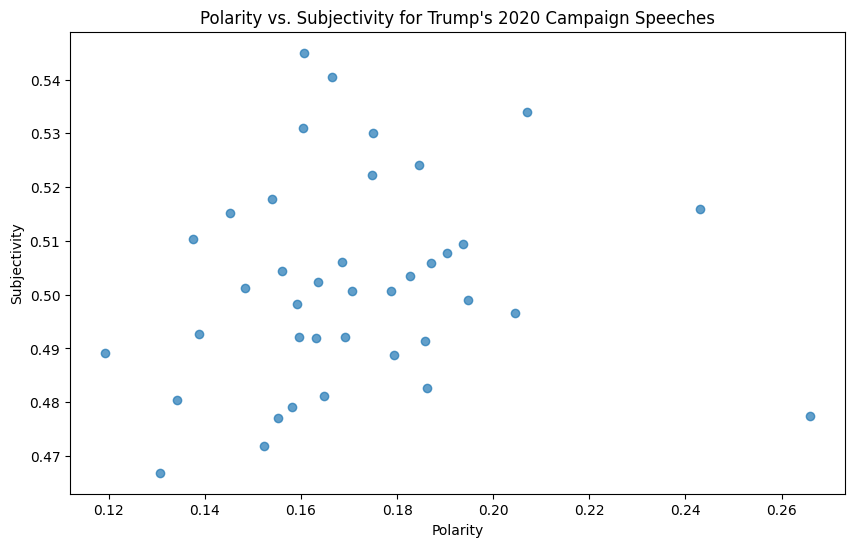

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Plot data for Trump speeches
plt.scatter(df['Polarity'], df['Subjectivity'], alpha=0.7)

# Add labels and title
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.title("Polarity vs. Subjectivity for Trump's 2020 Campaign Speeches")

# Display the plot
plt.show()

# Topic Modelling

In [ ]:
all_speeches_text = " ".join(df['Speech'].tolist())

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import contractions

# Function to expand contractions before passing to CountVectorizer
def expand_contractions(text):
    return contractions.fix(text)

# Sample multi-document corpus
documents = df['Speech']

# Expand contractions in the documents
expanded_documents = [expand_contractions(doc) for doc in documents]

# Preprocessing and vectorization pipeline
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(expanded_documents)

# Apply NMF with adjusted max_iter and tol
nmf = NMF(n_components=7, max_iter=1000, tol=1e-4, init='nndsvd', random_state=42)  # Increased max_iter and set init method
nmf.fit(X)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Function to find the words most affiliated with a given input word
def find_affiliated_words(input_word, nmf, vectorizer, n_top_words=15):
    if input_word not in vectorizer.get_feature_names_out():
        print(f"The word '{input_word}' is not in the vocabulary.")
        return

    word_index = vectorizer.get_feature_names_out().tolist().index(input_word)
    topic_word_dist = nmf.components_

    topic_weights = topic_word_dist[:, word_index]
    most_affiliated_topic = np.argmax(topic_weights)

    print(f"The word '{input_word}' is most affiliated with Topic #{most_affiliated_topic + 1}")

    # Get the top words for this topic
    top_word_indices = topic_word_dist[most_affiliated_topic].argsort()[:-n_top_words - 1:-1]
    top_words = [words[i] for i in top_word_indices]

    return top_words

# Check with 'economy'
top_words_for_economy = find_affiliated_words("economy", nmf, vectorizer)
print("Words most affiliated with 'economy':", top_words_for_economy)



The word 'economy' is most affiliated with Topic #2
Words most affiliated with 'economy': ['biden', 'china', 'america', 'joe', 'country', 'thank', 'years', 'american', 'want', 'know', 'did', 'great', 'jobs', 'world', 'new']


In [ ]:
top_words_for_healthcare = find_affiliated_words("healthcare", nmf, vectorizer)
print("Words most affiliated with 'healthcare':", top_words_for_healthcare)


The word 'healthcare' is most affiliated with Topic #3
Words most affiliated with 'healthcare': ['great', 'people', 'right', 'new', 'thank', 'years', 'american', 'want', 'going', 'know', 'country', 'america', 'party', 'like', 'democrats']


In [ ]:
top_words_for_crime = find_affiliated_words("crime", nmf, vectorizer)
print("Words most affiliated with 'crime':", top_words_for_crime)


The word 'crime' is most affiliated with Topic #5
Words most affiliated with 'crime': ['going', 'want', 'people', 'right', 'did', 'like', 'just', 'know', 'say', 'new', 'great', 'look', 'country', 'way', 'think']


In [ ]:
top_words_for_foreign_policy = find_affiliated_words("foreign policy", nmf, vectorizer)
print("Words most affiliated with 'foreign policy':", top_words_for_foreign_policy)

The word 'foreign policy' is not in the vocabulary.
Words most affiliated with 'foreign policy': None


In [ ]:
top_words_for_immigration = find_affiliated_words("immigration", nmf, vectorizer)
print("Words most affiliated with 'immigration':", top_words_for_immigration)

The word 'immigration' is most affiliated with Topic #3
Words most affiliated with 'immigration': ['great', 'people', 'right', 'new', 'thank', 'years', 'american', 'want', 'going', 'know', 'country', 'america', 'party', 'like', 'democrats']


This function takes a list of words rather than a single word to more accurately place a core voter issue into a topic within Trump's speeches.

In [ ]:
def find_and_display_affiliated_words(input_words, nmf, vectorizer, n_top_words=10):
    """
    Finds the words most affiliated with topics for a list of input words and displays the results.
    Also determines and displays the most popular topic overall.

    Args:
        input_words (list): List of input words to analyze.
        nmf (NMF): Trained NMF model.
        vectorizer (CountVectorizer): Trained CountVectorizer.
        n_top_words (int): Number of top words to display for each topic.

    Returns:
        None
    """
    results = {}
    topic_counts = {}  # Dictionary to count occurrences of each topic
    topic_word_dist = nmf.components_
    words = vectorizer.get_feature_names_out()

    for input_word in input_words:
        if input_word not in words:
            results[input_word] = f"'{input_word}' is not in the vocabulary."
            continue

        word_index = words.tolist().index(input_word)
        topic_weights = topic_word_dist[:, word_index]
        most_affiliated_topic = np.argmax(topic_weights)

        # Increment the topic count
        topic_counts[most_affiliated_topic] = topic_counts.get(most_affiliated_topic, 0) + 1

        # Get the top words for this topic
        top_word_indices = topic_word_dist[most_affiliated_topic].argsort()[:-n_top_words - 1:-1]
        top_words = [words[i] for i in top_word_indices]

        results[input_word] = {
            "Most Affiliated Topic": most_affiliated_topic + 1,
            "Top Words": top_words
        }

    # Find the most popular topic
    most_popular_topic = max(topic_counts, key=topic_counts.get, default=None)

    # Display the results
    for word, details in results.items():
        if isinstance(details, str):  # Handle missing words
            print(f"{word}: {details}")
        else:
            print(f"{word} is most affiliated with Topic #{details['Most Affiliated Topic']}")
            print(f"Top words: {', '.join(details['Top Words'])}")
            print()

    # Display the most popular topic overall
    if most_popular_topic is not None:
        print(f"The overall most popular topic is Topic #{most_popular_topic + 1}")
    else:
        print("No topics were affiliated with the input words.")



In [ ]:
input_words = economy_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

economic is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

growth is most affiliated with Topic #4
Top words: said, going, people, great, got, say, right, know, did, think

recession is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

economies is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

recovery is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

downturn: 'downturn' is not in the vocabulary.
slowdown: 'slowdown' is not in the vocabulary.
slowing: 'slowing' is not in the vocabulary.
sector is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

crisis is most affiliated with Topic #4
Top words: said, going, people, great, got, say, right, know, did, think

The ov

In [ ]:
input_words = healthcare_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

health is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

care is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

services is most affiliated with Topic #5
Top words: going, want, people, right, did, like, just, know, say, new

medicare is most affiliated with Topic #4
Top words: said, going, people, great, got, say, right, know, did, think

medical is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

insurance is most affiliated with Topic #6
Top words: thank, going, great, people, know, want, said, black, like, years

education is most affiliated with Topic #4
Top words: said, going, people, great, got, say, right, know, did, think

provider: 'provider' is not in the vocabulary.
providers is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, kn

In [ ]:
input_words = crime_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

criminal is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

crimes is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

murder is most affiliated with Topic #6
Top words: thank, going, great, people, know, want, said, black, like, years

trafficking is most affiliated with Topic #7
Top words: said, people, did, going, right, know, got, great, like, think

terrorism is most affiliated with Topic #4
Top words: said, going, people, great, got, say, right, know, did, think

homicide: 'homicide' is not in the vocabulary.
corruption is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

criminals is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

gang is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, wa

In [ ]:
input_words = foreign_policy_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

policies is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

government is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

affairs is most affiliated with Topic #5
Top words: going, want, people, right, did, like, just, know, say, new

administration is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

economic is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

finance is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

security is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

official is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

ministr

In [ ]:
input_words = immigration_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

immigrants is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

naturalization: 'naturalization' is not in the vocabulary.
enforcement is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

legislation is most affiliated with Topic #6
Top words: thank, going, great, people, know, want, said, black, like, years

laws is most affiliated with Topic #1
Top words: said, know, going, did, right, got, like, great, think, people

immigrant is most affiliated with Topic #6
Top words: thank, going, great, people, know, want, said, black, like, years

law is most affiliated with Topic #2
Top words: biden, china, america, joe, country, thank, years, american, want, know

illegal is most affiliated with Topic #3
Top words: great, people, right, new, thank, years, american, want, going, know

legal is most affiliated with Topic #4
Top words: said, going, people, great, got, say,

# NYT NLP

In [15]:
url = "https://raw.githubusercontent.com/jinkim-com/qm2coursework/refs/heads/main/nyt_file.csv"
df2 = pd.read_csv(url)

# Cleaning the Data

In [16]:
# Removing all isntances of \n

df2['text'] = df2['text'].str.replace('\n', '', regex=False)

In [17]:
df2['Date'] = pd.to_datetime(df2['Date'])
cutoff_date = pd.to_datetime('2020-11-06')
df2 = df2[df2['Date'] <= cutoff_date]
df2.head()

,Date,text
0,2020-07-30,Obama (Privately) Slams Trump - Raking in cash...
1,2020-09-09,Democrats Fear Partisan Slant at Postal Servic...
2,2020-10-08,"Pence, a peerless Trump defender, confronted h..."
3,2020-01-04,White House Withholds 20 Emails Between Two Tr...
4,2020-03-22,Trump Bets Business Will Answer Call to Fight ...


# Finding the frequency of regular expressions affliated with voter issues

Total mentions of Economy: 86
mean    0.042786
std     0.225679
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     3.000000
Name: economic, dtype: float64


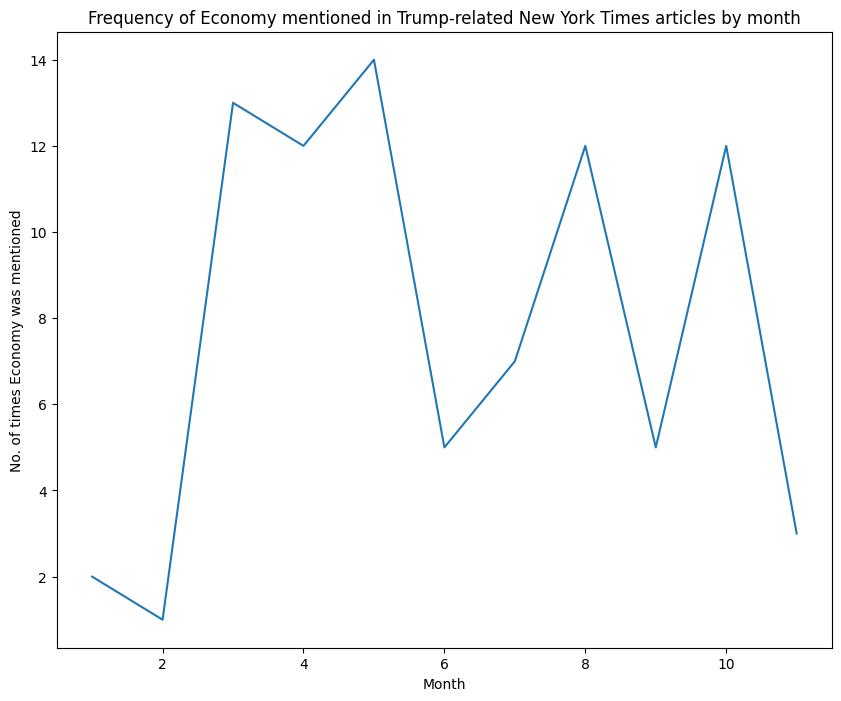

,economic
Month,
1,2
2,1
3,13
4,12
5,14
6,5
7,7
8,12
9,5


In [18]:
count_words(df2, economy_top10, 'Economy', 'text', 'Trump-related New York Times articles')

Total mentions of Healthcare: 171
mean    0.085075
std     0.399385
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     6.000000
Name: health, dtype: float64


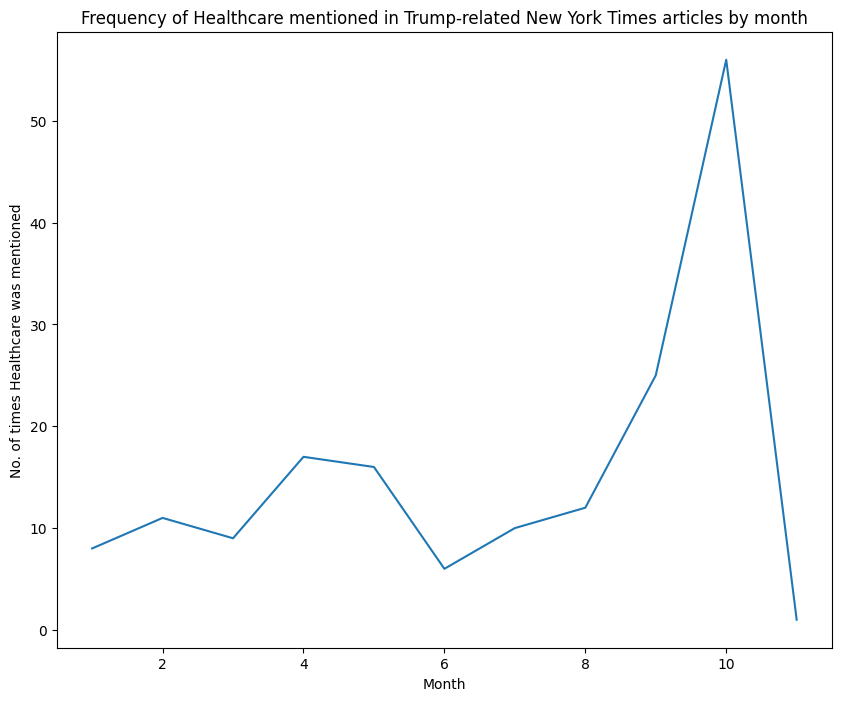

,health
Month,
1,8
2,11
3,9
4,17
5,16
6,6
7,10
8,12
9,25


In [19]:
count_words(df2, healthcare_top10, 'Healthcare', 'text', 'Trump-related New York Times articles')

Total mentions of Crime: 29
mean    0.014428
std     0.127349
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     2.000000
Name: criminal, dtype: float64


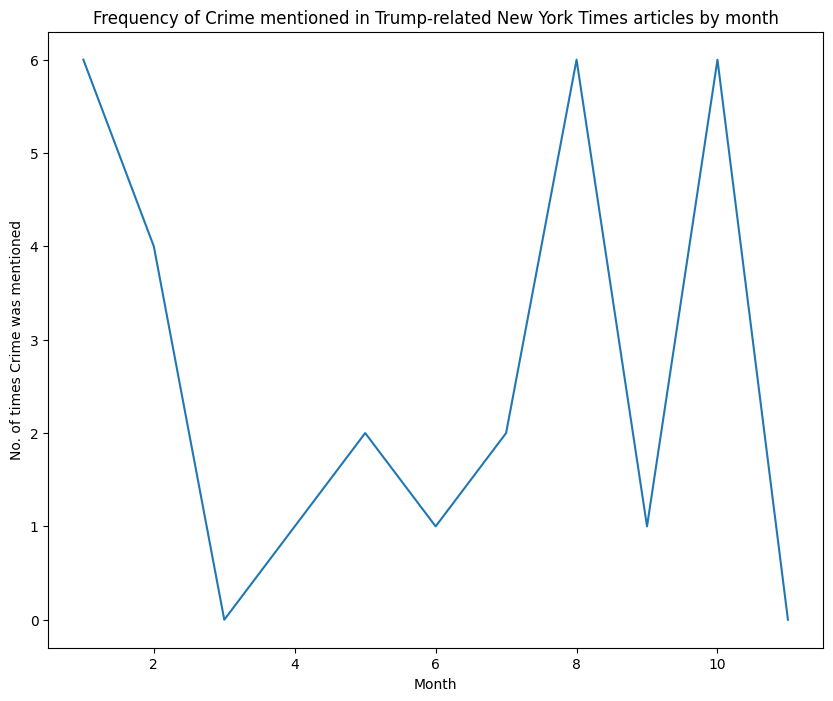

,criminal
Month,
1,6
2,4
3,0
4,1
5,2
6,1
7,2
8,6
9,1


In [20]:
count_words(df2, crime_top10, 'Crime', 'text', 'Trump-related New York Times articles')

Total mentions of Foreign Policy: 409
mean    0.203483
std     0.502743
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     4.000000
Name: policies, dtype: float64


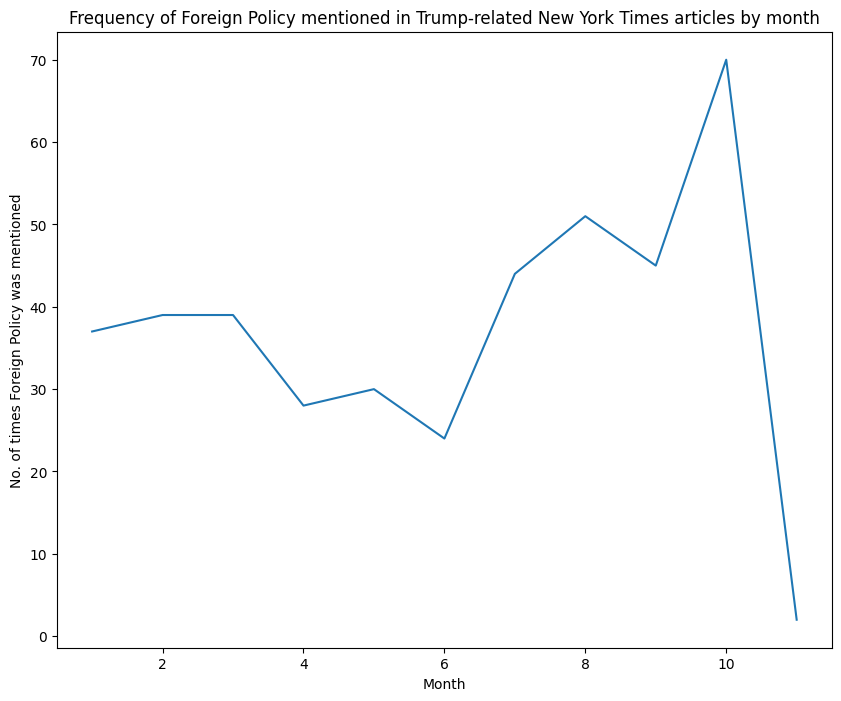

,policies
Month,
1,37
2,39
3,39
4,28
5,30
6,24
7,44
8,51
9,45


In [21]:
count_words(df2, foreign_policy_top10, 'Foreign Policy', 'text', 'Trump-related New York Times articles')

Total mentions of Immigration: 227
mean    0.112935
std     0.437971
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     5.000000
Name: immigrants, dtype: float64


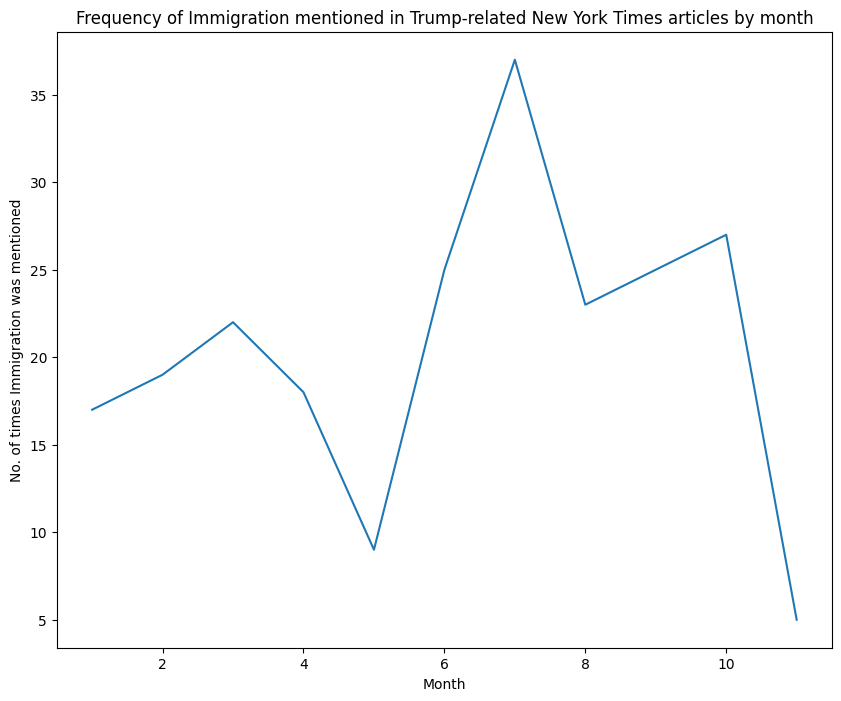

,immigrants
Month,
1,17
2,19
3,22
4,18
5,9
6,25
7,37
8,23
9,25


In [22]:
count_words(df2, immigration_top10, 'Immigration', 'text', 'Trump-related New York Times articles')

# Sentiment Analysis


In [23]:
df2['Polarity'], df2['Subjectivity'] = get_sentiment_scores_batch(df2['text']) # Assign the results to both columns
df2.head()

NameError: name 'get_sentiment_scores_batch' is not defined

In [ ]:
summary_stats_pol = df2['Polarity'].round(1).describe().T
filtered_stats = summary_stats_pol.drop(['count'])
print(f"Summary Statistics for Polarity Scores for Trump-related New York Times' articles : \n{filtered_stats}")

summary_stats_sub = df2['Subjectivity'].round(1).describe().T
filtered_stats = summary_stats_sub.drop(['count'])
print(f"\nSummary Statistics for Subjectivity Scores for Trump-related New York Times' articles: \n{filtered_stats}")

Summary Statistics for Polarity Scores for Trump-related New York Times' articles : 
mean    0.052935
std     0.190553
min    -1.000000
25%     0.000000
50%     0.000000
75%     0.200000
max     1.000000
Name: Polarity, dtype: float64

Summary Statistics for Subjectivity Scores for Trump-related New York Times' articles: 
mean    0.374080
std     0.246246
min     0.000000
25%     0.200000
50%     0.400000
75%     0.500000
max     1.000000
Name: Subjectivity, dtype: float64


KeyError: 'Polarity'

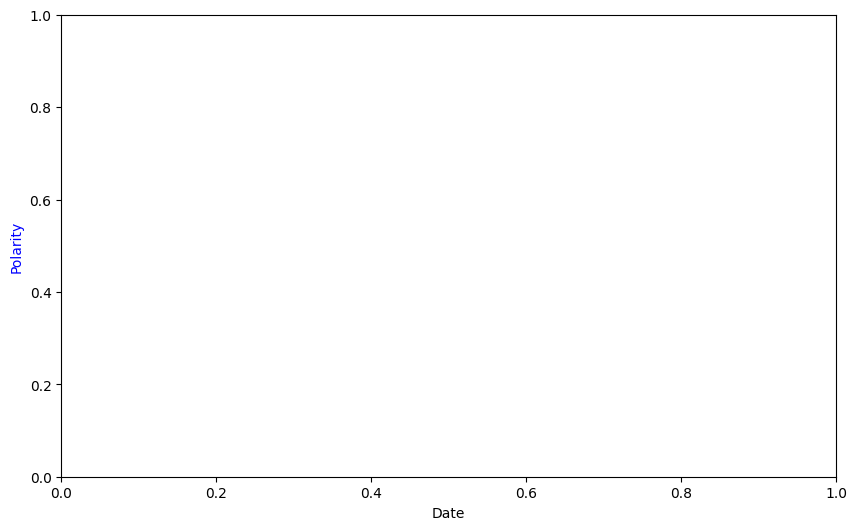

In [ ]:
# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for Polarity on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Polarity', color='blue')
ax1.scatter(df2['Date'], df2['Polarity'], color='blue', alpha=0.7)  # Scatter plot
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Add title
plt.title('Polarity over Time (Trump-related New York Times articles)')

# Display the plot
plt.show()

# Topic Modelling

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import contractions

# Function to expand contractions before passing to CountVectorizer
def expand_contractions(text):
    return contractions.fix(text)

# Sample multi-document corpus
documents = df2['text']

# Expand contractions in the documents
expanded_documents = [expand_contractions(doc) for doc in documents]

# Preprocessing and vectorization pipeline
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(expanded_documents)

# Apply NMF with adjusted max_iter and tol
nmf = NMF(n_components=7, max_iter=1000, tol=1e-4, init='nndsvd', random_state=42)  # Increased max_iter and set init method
nmf.fit(X)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Function to find the words most affiliated with a given input word
def find_affiliated_words(input_word, nmf, vectorizer, n_top_words=15):
    if input_word not in vectorizer.get_feature_names_out():
        print(f"The word '{input_word}' is not in the vocabulary.")
        return

    word_index = vectorizer.get_feature_names_out().tolist().index(input_word)
    topic_word_dist = nmf.components_

    topic_weights = topic_word_dist[:, word_index]
    most_affiliated_topic = np.argmax(topic_weights)

    print(f"The word '{input_word}' is most affiliated with Topic #{most_affiliated_topic + 1}")

    # Get the top words for this topic
    top_word_indices = topic_word_dist[most_affiliated_topic].argsort()[:-n_top_words - 1:-1]
    top_words = [words[i] for i in top_word_indices]

    return top_words

# Check with 'economy'
top_words_for_economy = find_affiliated_words("economy", nmf, vectorizer)
print("Words most affiliated with 'economy':", top_words_for_economy)

The word 'economy' is most affiliated with Topic #5
Words most affiliated with 'economy': ['coronavirus', 'new', 'virus', 'trump', 'pandemic', 'cases', 'health', 'response', 'country', 'york', 'states', 'administration', 'rally', '000', 'united']


In [ ]:
top_words_for_healthcare = find_affiliated_words("health", nmf, vectorizer)
print("Words most affiliated with 'healthcare':", top_words_for_healthcare)


The word 'health' is most affiliated with Topic #5
Words most affiliated with 'healthcare': ['coronavirus', 'new', 'virus', 'trump', 'pandemic', 'cases', 'health', 'response', 'country', 'york', 'states', 'administration', 'rally', '000', 'united']


In [ ]:
top_words_for_crime = find_affiliated_words("crime", nmf, vectorizer)
print("Words most affiliated with 'crime':", top_words_for_crime)

The word 'crime' is most affiliated with Topic #3
Words most affiliated with 'crime': ['president', 'trump', 'said', 'says', 'obama', 'news', 'vice', 'american', 'democrats', 'senator', 'twitter', 'public', 'speech', 'impeachment', 'barack']


In [ ]:
top_words_for_foreign_policy = find_affiliated_words("foreign", nmf, vectorizer)
print("Words most affiliated with 'foreign policy':", top_words_for_foreign_policy)

The word 'foreign' is most affiliated with Topic #1
Words most affiliated with 'foreign policy': ['trump', 'mr', 'said', 'republican', 'convention', 'administration', 'national', 'voters', 'state', 'impeachment', 'senate', 'officials', 'democrats', 'donald', 'says']


In [ ]:
top_words_for_immigration = find_affiliated_words("immigration", nmf, vectorizer)
print("Words most affiliated with 'immigration':", top_words_for_immigration)

The word 'immigration' is most affiliated with Topic #1
Words most affiliated with 'immigration': ['trump', 'mr', 'said', 'republican', 'convention', 'administration', 'national', 'voters', 'state', 'impeachment', 'senate', 'officials', 'democrats', 'donald', 'says']


These are the results for the topic modelling method done using a list of words rather than just a single word relating to a voter issue.

In [ ]:
input_words = economy_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

economic is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

growth: 'growth' is not in the vocabulary.
recession is most affiliated with Topic #5
Top words: coronavirus, new, virus, trump, pandemic, cases, health, response, country, york

economies is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

recovery is most affiliated with Topic #2
Top words: biden, trump, joseph, jr, joe, debate, mr, presidential, voters, poll

downturn: 'downturn' is not in the vocabulary.
slowdown: 'slowdown' is not in the vocabulary.
slowing: 'slowing' is not in the vocabulary.
sector is most affiliated with Topic #7
Top words: election, court, trump, supreme, democrats, mail, new, voting, republicans, vote

crisis is most affiliated with Topic #5
Top words: coronavirus, new, virus, trump, pandemic, cases, health, response, country, y

In [ ]:
input_words = healthcare_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

health is most affiliated with Topic #5
Top words: coronavirus, new, virus, trump, pandemic, cases, health, response, country, york

care is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

services is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

medicare is most affiliated with Topic #2
Top words: biden, trump, joseph, jr, joe, debate, mr, presidential, voters, poll

medical is most affiliated with Topic #5
Top words: coronavirus, new, virus, trump, pandemic, cases, health, response, country, york

insurance is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

education is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

provider: 'provider

In [ ]:
input_words = crime_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

criminal is most affiliated with Topic #3
Top words: president, trump, said, says, obama, news, vice, american, democrats, senator

crimes is most affiliated with Topic #3
Top words: president, trump, said, says, obama, news, vice, american, democrats, senator

murder is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

trafficking is most affiliated with Topic #4
Top words: house, white, impeachment, said, trump, day, aides, monday, tested, staff

terrorism is most affiliated with Topic #4
Top words: house, white, impeachment, said, trump, day, aides, monday, tested, staff

homicide: 'homicide' is not in the vocabulary.
corruption is most affiliated with Topic #5
Top words: coronavirus, new, virus, trump, pandemic, cases, health, response, country, york

criminals is most affiliated with Topic #7
Top words: election, court, trump, supreme, democrats, mail, new, voting, republicans, vote

gang: 'gang'

In [ ]:
input_words = foreign_policy_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

policies is most affiliated with Topic #7
Top words: election, court, trump, supreme, democrats, mail, new, voting, republicans, vote

government is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

affairs is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

administration is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

economic is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

finance is most affiliated with Topic #6
Top words: campaign, trump, rally, ads, million, manager, trail, parscale, ad, tulsa

security is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impe

In [ ]:
input_words = immigration_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

immigrants is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

naturalization is most affiliated with Topic #6
Top words: campaign, trump, rally, ads, million, manager, trail, parscale, ad, tulsa

enforcement is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

legislation is most affiliated with Topic #4
Top words: house, white, impeachment, said, trump, day, aides, monday, tested, staff

laws is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

immigrant is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

law is most affiliated with Topic #1
Top words: trump, mr, said, republican, convention, administration, national, voters, state, impeachment

# 'Economy' Frequency Analysis

Total mentions of Economy: 86
mean    0.042786
std     0.225679
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     3.000000
Name: economic, dtype: float64


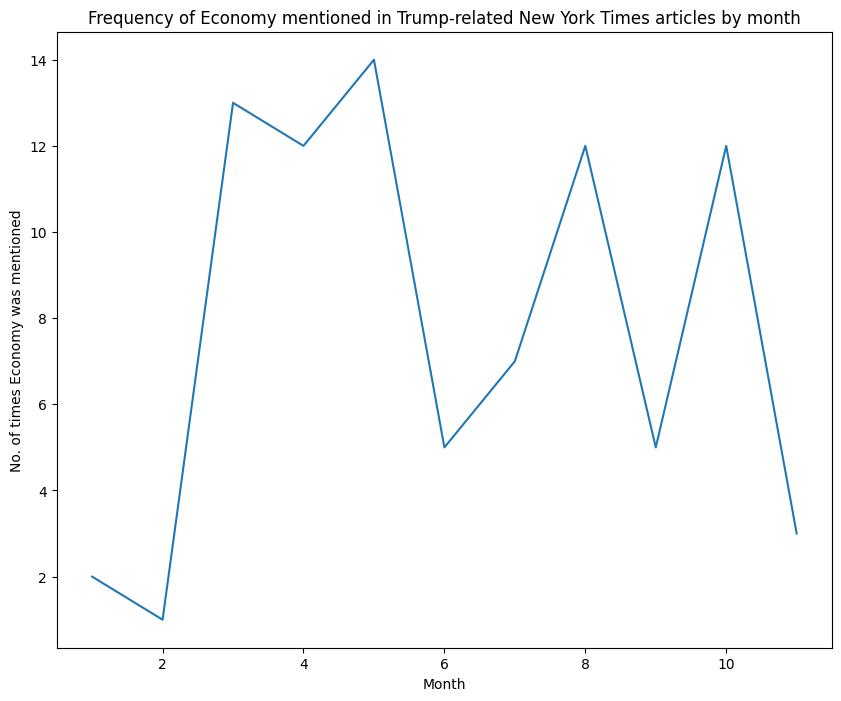

Total mentions of Economy: 94
mean     2.410256
std      2.711748
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     14.000000
Name: economic, dtype: float64


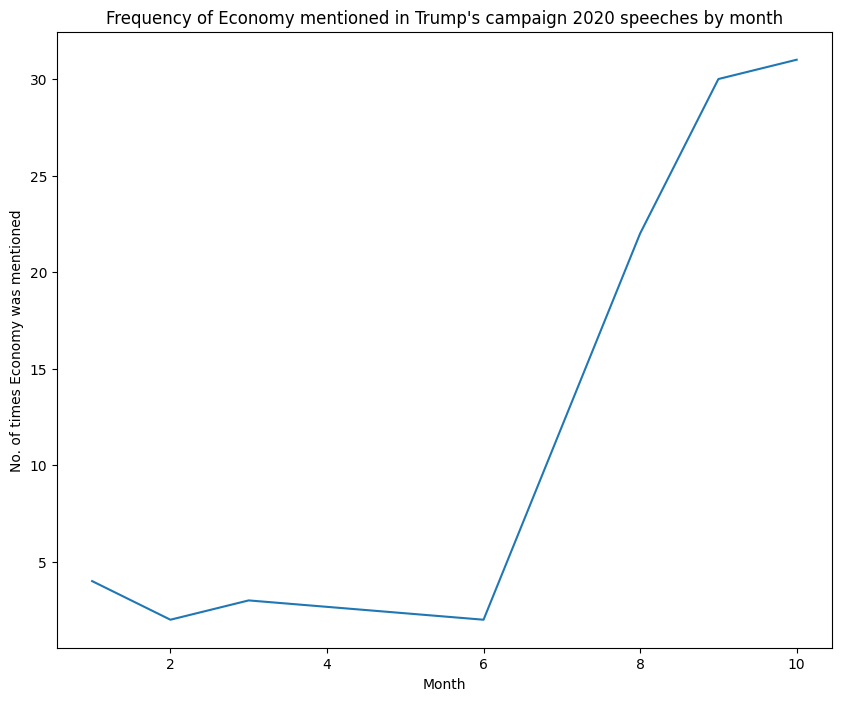

In [24]:
nyteconomy = count_words(df2, economy_top10, 'Economy', 'text', 'Trump-related New York Times articles')
nyteconomy = nyteconomy.reset_index()

# Rename the columns for clarity
nyteconomy.columns = ['Month', 'Frequency']

speecheconomy = count_words(df, economy_top10, 'Economy', 'Speech', "Trump's campaign 2020 speeches")
speecheconomy = speecheconomy.reset_index()

# Rename the columns for clarity
speecheconomy.columns = ['Month', 'Frequency']


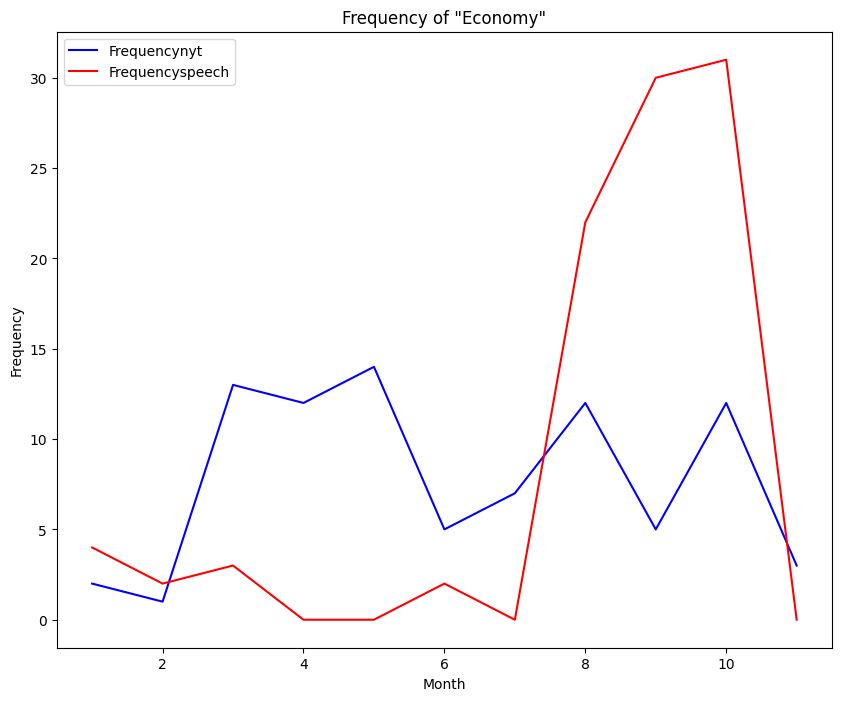

In [50]:

# Combine the two datasets
combined_df = pd.merge(nyteconomy, speecheconomy, on='Month', how='outer', suffixes=('nyt', 'speech'))
combined_df.fillna(0, inplace=True)
combined_df.set_index('Month', inplace=True)

combined_df
plt.plot(combined_df.index, combined_df['Frequencynyt'], label='Frequencynyt', color='blue')  # First line with blue color
plt.plot(combined_df.index, combined_df['Frequencyspeech'], label='Frequencyspeech', color='red')  # Second line with orange color
plt.legend()
plt.title('Frequency of "Economy"')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

In [26]:
import numpy as np
from scipy.stats import shapiro, kstest
import statsmodels.api as sm
import matplotlib.pyplot as plt


X = sm.add_constant(combined_df['Frequencynyt'])
model = sm.OLS(combined_df['Frequencyspeech'], X).fit()

residuals = model.resid

_, p_shapiro = shapiro(residuals)
print(f"Shapiro-Wilk Test p-value: {p_shapiro:.3f}")

if p_shapiro > 0.05:
    print("Residuals are normally distributed. OLS assumptions are met.")
else:
    print("Residuals are not normally distributed. Consider alternative methods.")

Shapiro-Wilk Test p-value: 0.010
Residuals are not normally distributed. Consider alternative methods.


In [ ]:
import numpy as np
n_iterations = 10000
bootstrap5_diffs = []

# Perform bootstrapping
for _ in range(n_iterations):
    # Resample with replacement
    nyt5_sample = np.random.choice(combined_df['Frequencynyt'], size=len(combined_df['Frequencynyt']), replace=True)
    speech5_sample = np.random.choice(combined_df['Frequencyspeech'], size=len(combined_df['Frequencyspeech']), replace=True)

    # Calculate the difference in means for the bootstrap samples
    diff_mean = np.mean(nyt5_sample) - np.mean(speech5_sample)
    bootstrap5_diffs.append(diff_mean)

# Convert the list of differences to a numpy array for easier analysis
bootstrap5_diffs = np.array(bootstrap5_diffs)

# Calculate the 95% confidence interval
conf5_interval = np.percentile(bootstrap5_diffs, [2.5, 97.5])

# Display the results
print(f"Bootstrap Confidence Interval (95% CI) for the Difference in Means: {conf5_interval}")
print(f"Bootstrap Mean Difference: {np.mean(bootstrap5_diffs)}")

# Check if the confidence interval includes 0 (indicating no significant difference)
if conf5_interval[0] > 0 or conf5_interval[1] < 0:
    print("There is a significant difference between the two distributions.")
else:
    print("There is no significant difference between the two distributions.")

Bootstrap Confidence Interval (95% CI) for the Difference in Means: [-8.90909091  6.27272727]
Bootstrap Mean Difference: -0.7059818181818182
There is no significant difference between the two distributions.


# 'Healthcare' Frequency Analysis

Total mentions of Healthcare: 171
mean    0.085075
std     0.399385
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     6.000000
Name: health, dtype: float64


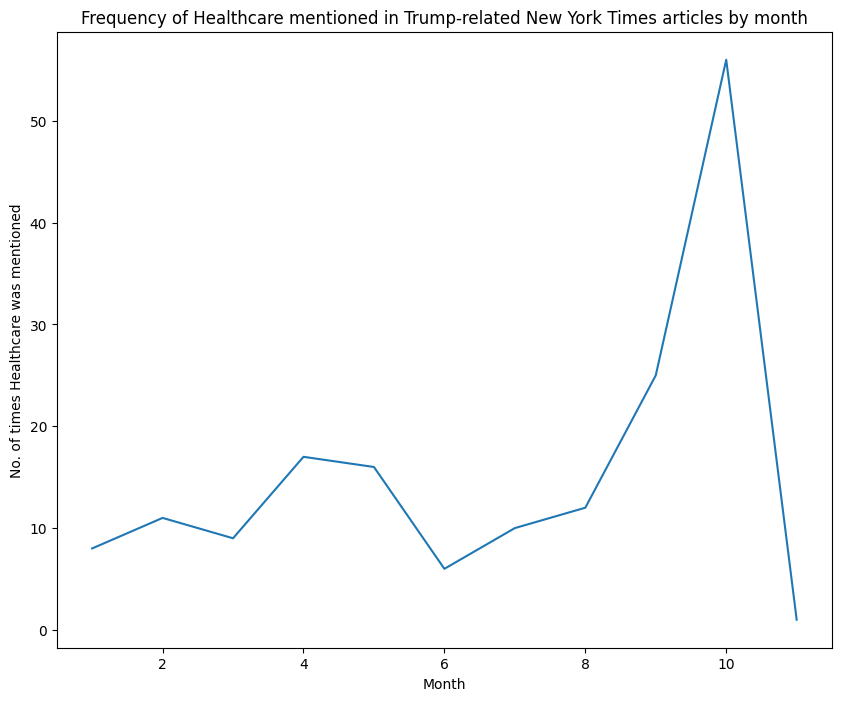

Total mentions of Healthcare: 470
mean    12.051282
std      7.887194
min      1.000000
25%      8.000000
50%     10.000000
75%     15.000000
max     37.000000
Name: health, dtype: float64


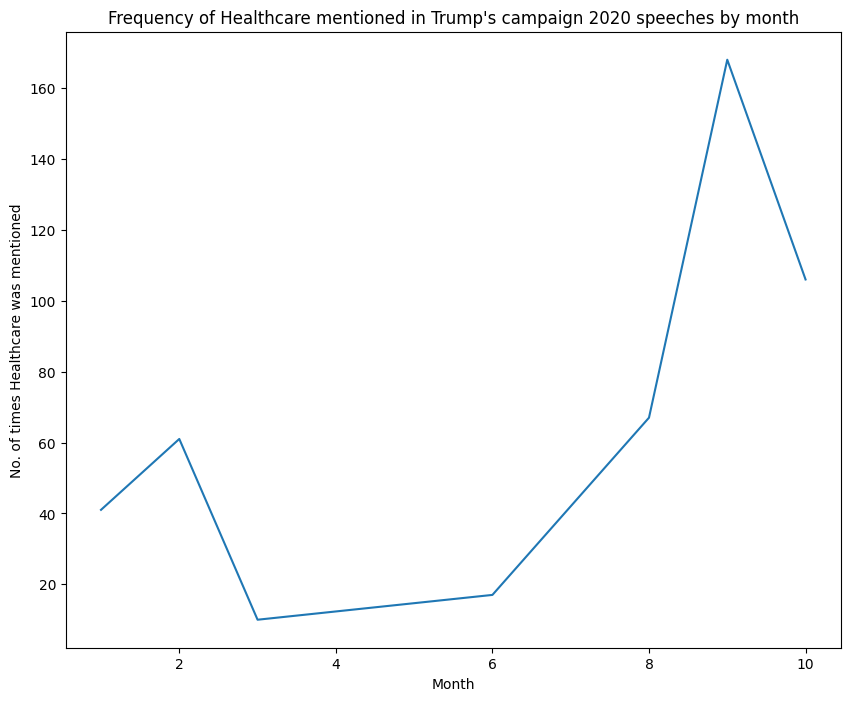

In [29]:
nythealthcare = count_words(df2, healthcare_top10, 'Healthcare', 'text', 'Trump-related New York Times articles')
nythealthcare = nythealthcare.reset_index()

# Rename the columns for clarity
nythealthcare.columns = ['Month', 'Frequency']

speechhealthcare = count_words(df, healthcare_top10, 'Healthcare', 'Speech', "Trump's campaign 2020 speeches")
speechhealthcare = speechhealthcare.reset_index()

# Rename the columns for clarity
speechhealthcare.columns = ['Month', 'Frequency']

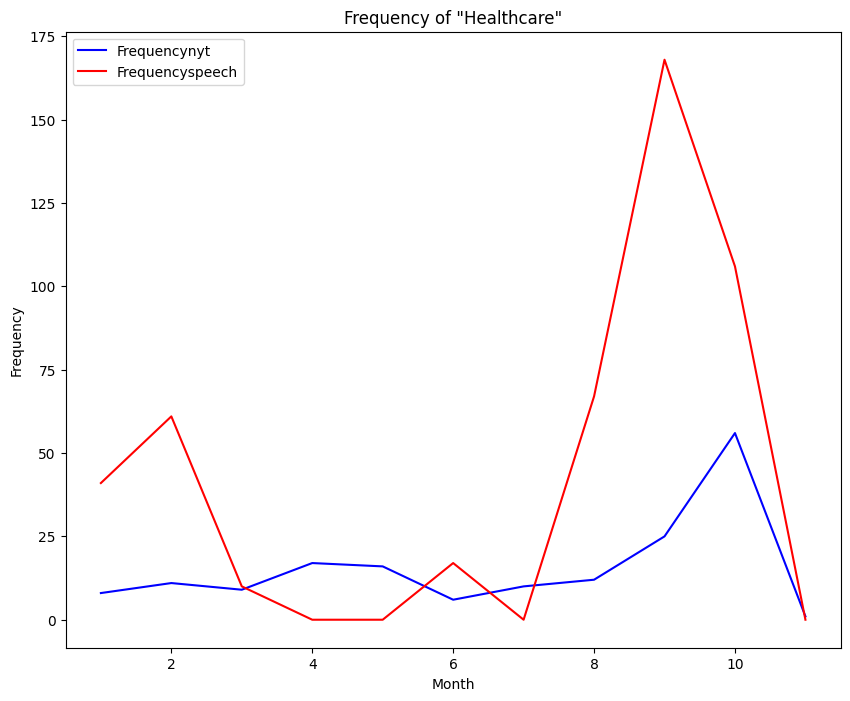

In [49]:
# Combine the two datasets
combined2_df = pd.merge(nythealthcare, speechhealthcare, on='Month', how='outer', suffixes=('nyt', 'speech'))
combined2_df.fillna(0, inplace=True)
combined2_df.set_index('Month', inplace=True)

combined2_df
plt.plot(combined2_df.index, combined2_df['Frequencynyt'], label='Frequencynyt', color='blue')  # First line with blue color
plt.plot(combined2_df.index, combined2_df['Frequencyspeech'], label='Frequencyspeech', color='red')  # Second line with orange color
plt.legend()
plt.title('Frequency of "Healthcare"')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

In [31]:
X = sm.add_constant(combined2_df['Frequencynyt'])
model = sm.OLS(combined2_df['Frequencyspeech'], X).fit()

residuals = model.resid

_, p_shapiro = shapiro(residuals)
print(f"Shapiro-Wilk Test p-value: {p_shapiro:.3f}")

if p_shapiro > 0.05:
    print("Residuals are normally distributed. OLS assumptions are met.")
else:
    print("Residuals are not normally distributed. Consider alternative methods.")

Shapiro-Wilk Test p-value: 0.101
Residuals are normally distributed. OLS assumptions are met.


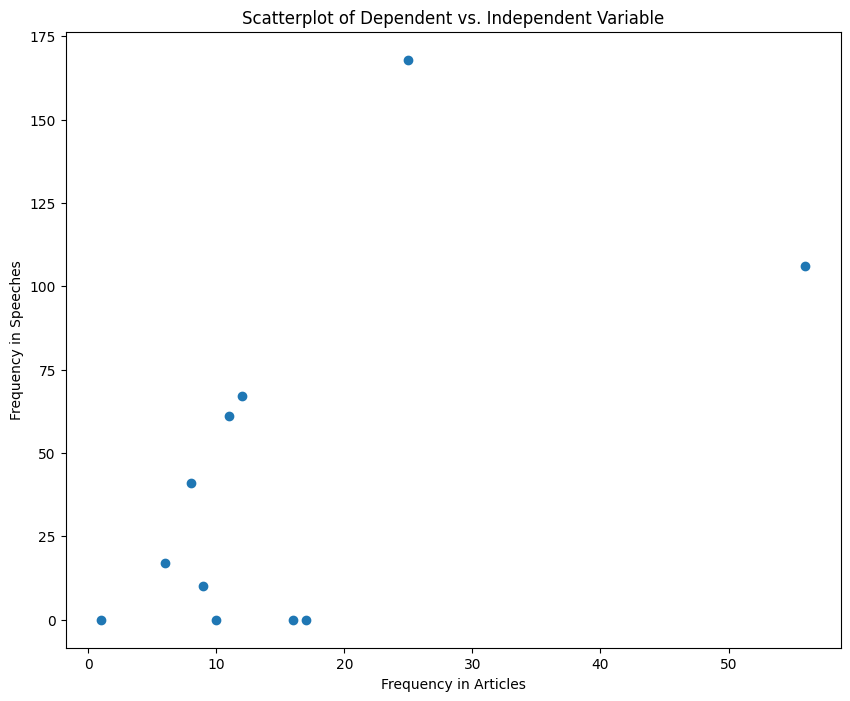

In [43]:
import matplotlib.pyplot as plt

plt.scatter(combined2_df['Frequencynyt'], combined2_df['Frequencyspeech'])
plt.xlabel('Frequency in Articles')
plt.ylabel('Frequency in Speeches')
plt.title('Scatterplot of Dependent vs. Independent Variable')
plt.show()

In [ ]:
import numpy as np
n_iterations = 10000
bootstrap4_diffs = []

# Perform bootstrapping
for _ in range(n_iterations):
    # Resample with replacement
    nyt4_sample = np.random.choice(combined2_df['Frequencynyt'], size=len(combined2_df['Frequencynyt']), replace=True)
    speech4_sample = np.random.choice(combined2_df['Frequencyspeech'], size=len(combined2_df['Frequencyspeech']), replace=True)

    # Calculate the difference in means for the bootstrap samples
    diff_mean = np.mean(nyt4_sample) - np.mean(speech4_sample)
    bootstrap4_diffs.append(diff_mean)

# Convert the list of differences to a numpy array for easier analysis
bootstrap4_diffs = np.array(bootstrap4_diffs)

# Calculate the 95% confidence interval
conf4_interval = np.percentile(bootstrap4_diffs, [2.5, 97.5])

# Display the results
print(f"Bootstrap Confidence Interval (95% CI) for the Difference in Means: {conf4_interval}")
print(f"Bootstrap Mean Difference: {np.mean(bootstrap4_diffs)}")

# Check if the confidence interval includes 0 (indicating no significant difference)
if conf4_interval[0] > 0 or conf4_interval[1] < 0:
    print("There is a significant difference between the two distributions.")
else:
    print("There is no significant difference between the two distributions.")

Bootstrap Confidence Interval (95% CI) for the Difference in Means: [-62.00227273   1.09090909]
Bootstrap Mean Difference: -27.407363636363634
There is no significant difference between the two distributions.


# 'Crime' Frequency Analysis

Total mentions of Crime: 29
mean    0.014428
std     0.127349
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     2.000000
Name: criminal, dtype: float64


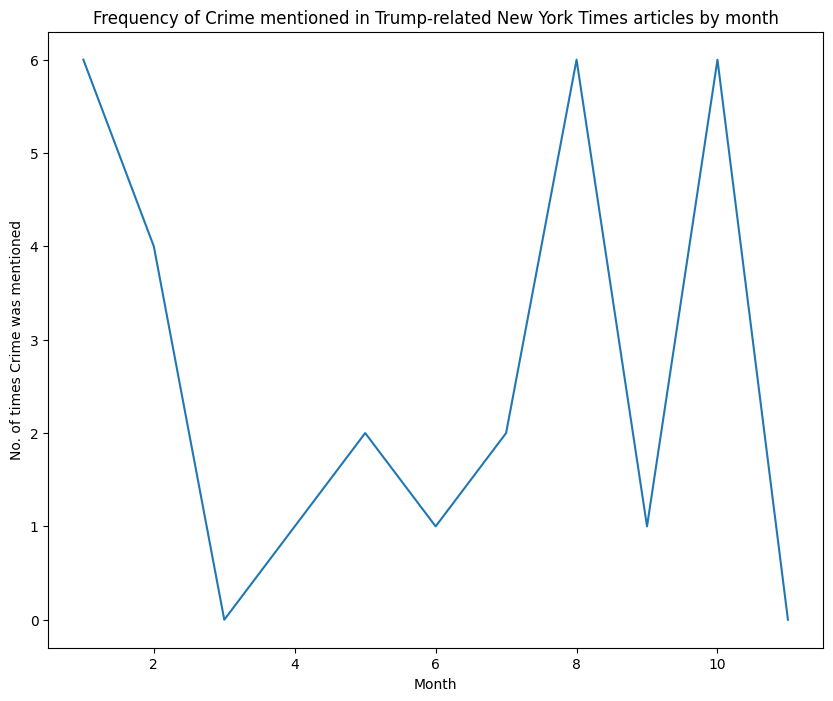

Total mentions of Crime: 277
mean     7.102564
std      4.369722
min      1.000000
25%      4.000000
50%      6.000000
75%      9.500000
max     16.000000
Name: criminal, dtype: float64


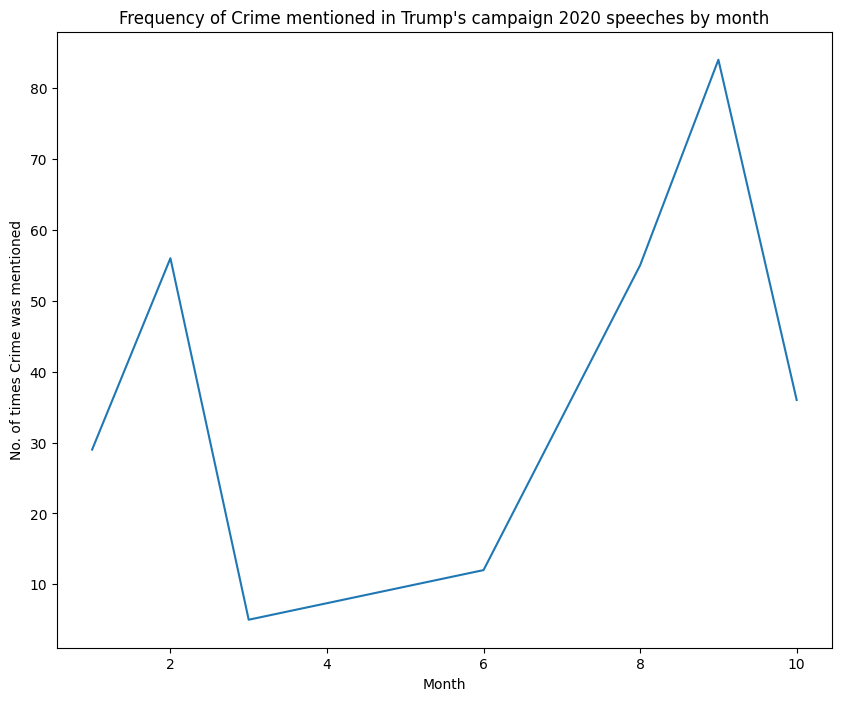

In [32]:
nytcrime = count_words(df2, crime_top10, 'Crime', 'text', 'Trump-related New York Times articles')
nytcrime = nytcrime.reset_index()

# Rename the columns for clarity
nytcrime.columns = ['Month', 'Frequency']

speechcrime = count_words(df, crime_top10, 'Crime', 'Speech', "Trump's campaign 2020 speeches")
speechcrime = speechcrime.reset_index()

# Rename the columns for clarity
speechcrime.columns = ['Month', 'Frequency']

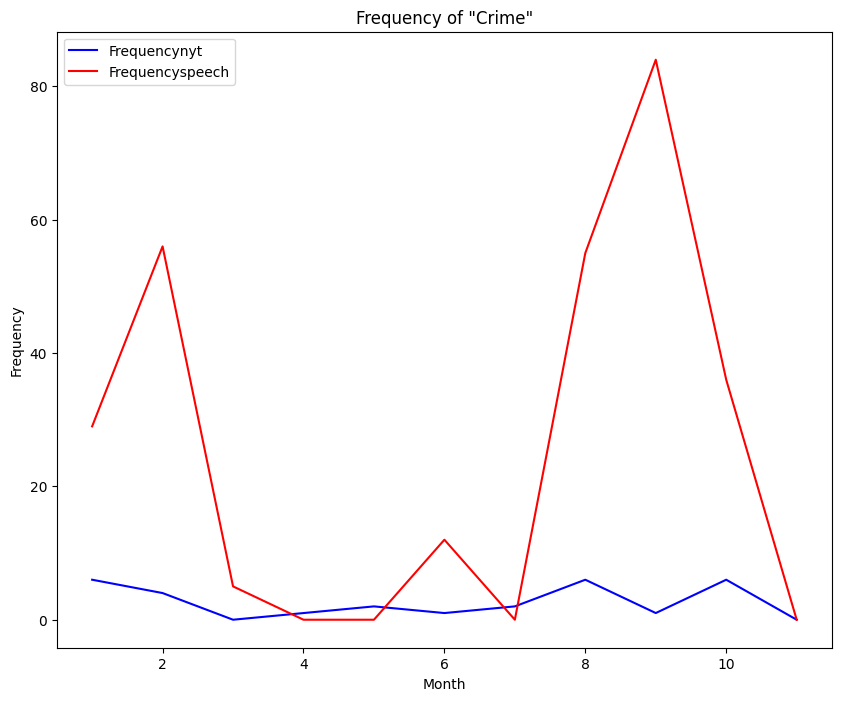

In [48]:
# Combine the two datasets
combined3_df = pd.merge(nytcrime, speechcrime, on='Month', how='outer', suffixes=('nyt', 'speech'))
combined3_df.fillna(0, inplace=True)
combined3_df.set_index('Month', inplace=True)

combined3_df
plt.plot(combined3_df.index, combined3_df['Frequencynyt'], label='Frequencynyt', color='blue')  # First line with blue color
plt.plot(combined3_df.index, combined3_df['Frequencyspeech'], label='Frequencyspeech', color='red')  # Second line with orange color
plt.legend()
plt.title('Frequency of "Crime"')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

In [34]:
X = sm.add_constant(combined3_df['Frequencynyt'])
model = sm.OLS(combined3_df['Frequencyspeech'], X).fit()

residuals = model.resid

_, p_shapiro = shapiro(residuals)
print(f"Shapiro-Wilk Test p-value: {p_shapiro:.3f}")

if p_shapiro > 0.05:
    print("Residuals are normally distributed. OLS assumptions are met.")
else:
    print("Residuals are not normally distributed. Consider alternative methods.")

Shapiro-Wilk Test p-value: 0.005
Residuals are not normally distributed. Consider alternative methods.


In [36]:
import numpy as np
n_iterations = 10000
bootstrap3_diffs = []

# Perform bootstrapping
for _ in range(n_iterations):
    # Resample with replacement
    nyt3_sample = np.random.choice(combined3_df['Frequencynyt'], size=len(combined3_df['Frequencynyt']), replace=True)
    speech3_sample = np.random.choice(combined3_df['Frequencyspeech'], size=len(combined3_df['Frequencyspeech']), replace=True)

    # Calculate the difference in means for the bootstrap samples
    diff_mean = np.mean(nyt3_sample) - np.mean(speech3_sample)
    bootstrap3_diffs.append(diff_mean)

# Convert the list of differences to a numpy array for easier analysis
bootstrap3_diffs = np.array(bootstrap3_diffs)

# Calculate the 95% confidence interval
conf3_interval = np.percentile(bootstrap3_diffs, [2.5, 97.5])

# Display the results
print(f"Bootstrap Confidence Interval (95% CI) for the Difference in Means: {conf3_interval}")
print(f"Bootstrap Mean Difference: {np.mean(bootstrap3_diffs)}")

# Check if the confidence interval includes 0 (indicating no significant difference)
if conf3_interval[0] > 0 or conf3_interval[1] < 0:
    print("There is a significant difference between the two distributions.")
else:
    print("There is no significant difference between the two distributions.")

Bootstrap Confidence Interval (95% CI) for the Difference in Means: [-40.          -7.18181818]
Bootstrap Mean Difference: -22.569418181818186
There is a significant difference between the two distributions.


# 'Foreign Policy' Frequency Comparison

Total mentions of Foreign Policy: 409
mean    0.203483
std     0.502743
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     4.000000
Name: policies, dtype: float64


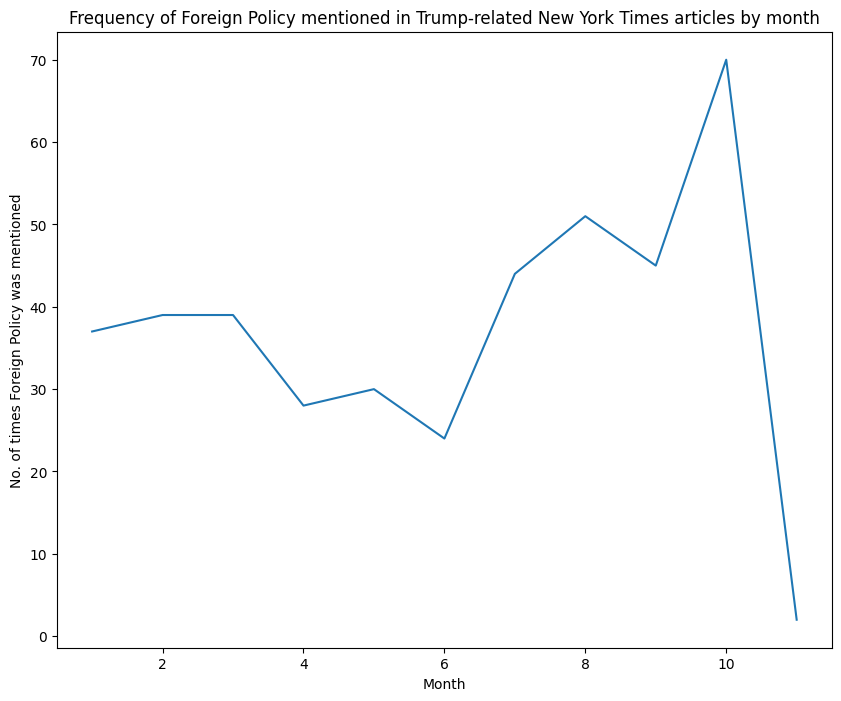

Total mentions of Foreign Policy: 560
mean    14.358974
std      6.076214
min      2.000000
25%     10.000000
50%     14.000000
75%     18.500000
max     29.000000
Name: policies, dtype: float64


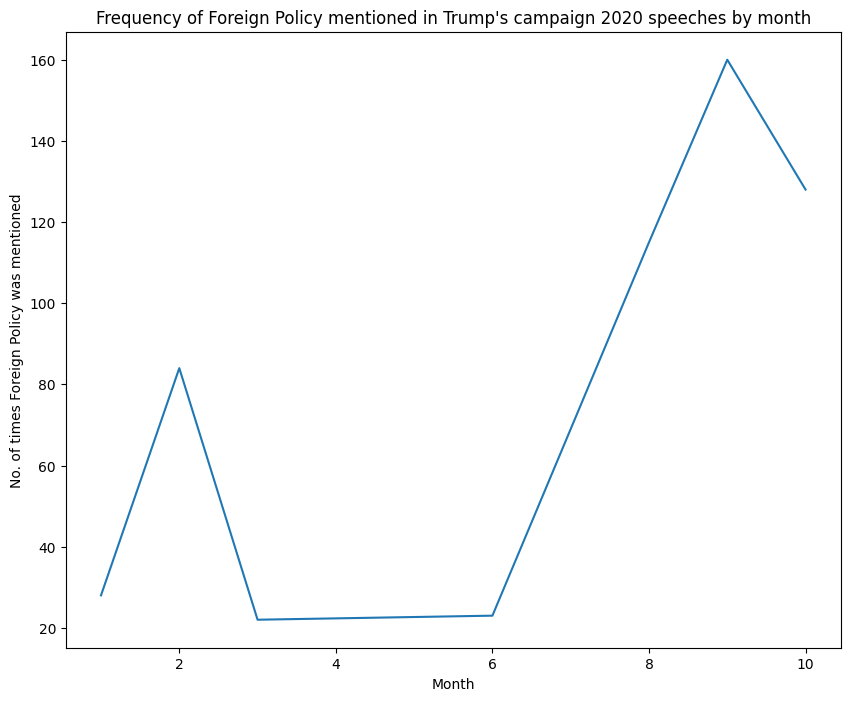

In [37]:
nytforeign = count_words(df2, foreign_policy_top10, 'Foreign Policy', 'text', 'Trump-related New York Times articles')
nytforeign = nytforeign.reset_index()

# Rename the columns for clarity
nytforeign.columns = ['Month', 'Frequency']

speechforeign = count_words(df, foreign_policy_top10, 'Foreign Policy', 'Speech', "Trump's campaign 2020 speeches")
speechforeign = speechforeign.reset_index()

# Rename the columns for clarity
speechforeign.columns = ['Month', 'Frequency']

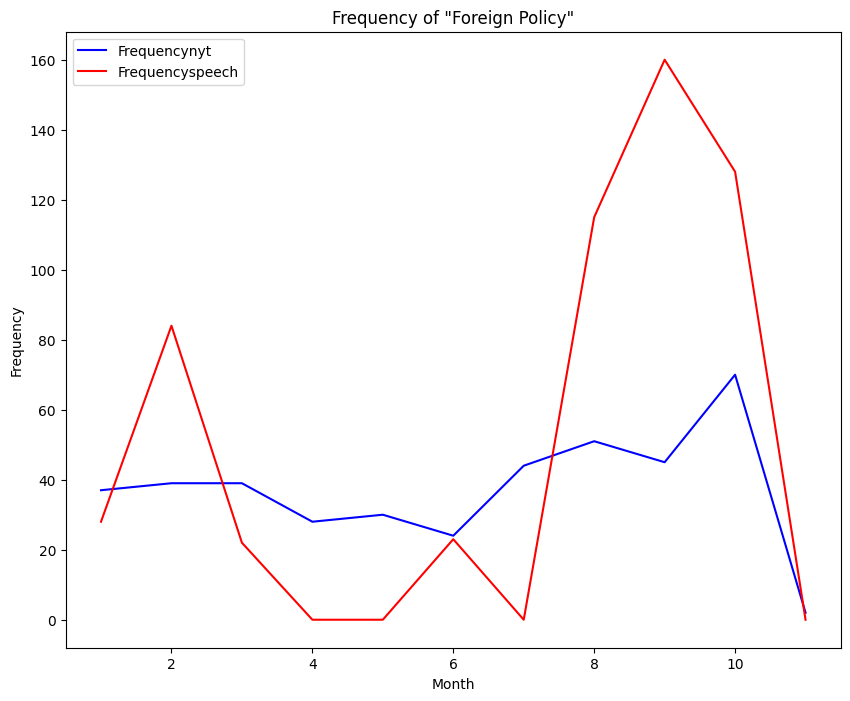

In [46]:
# Combine the two datasets
combined4_df = pd.merge(nytforeign, speechforeign, on='Month', how='outer', suffixes=('nyt', 'speech'))
combined4_df.fillna(0, inplace=True)
combined4_df.set_index('Month', inplace=True)

combined4_df


plt.plot(combined4_df.index, combined4_df['Frequencynyt'], label='Frequencynyt', color='blue')  # First line with blue color
plt.plot(combined4_df.index, combined4_df['Frequencyspeech'], label='Frequencyspeech', color='red')  # Second line with orange color
plt.legend()
plt.title('Frequency of "Foreign Policy"')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

In [39]:
X = sm.add_constant(combined4_df['Frequencynyt'])
model = sm.OLS(combined4_df['Frequencyspeech'], X).fit()

residuals = model.resid

_, p_shapiro = shapiro(residuals)
print(f"Shapiro-Wilk Test p-value: {p_shapiro:.3f}")

if p_shapiro > 0.05:
    print("Residuals are normally distributed. OLS assumptions are met.")
else:
    print("Residuals are not normally distributed. Consider alternative methods.")

Shapiro-Wilk Test p-value: 0.633
Residuals are normally distributed. OLS assumptions are met.


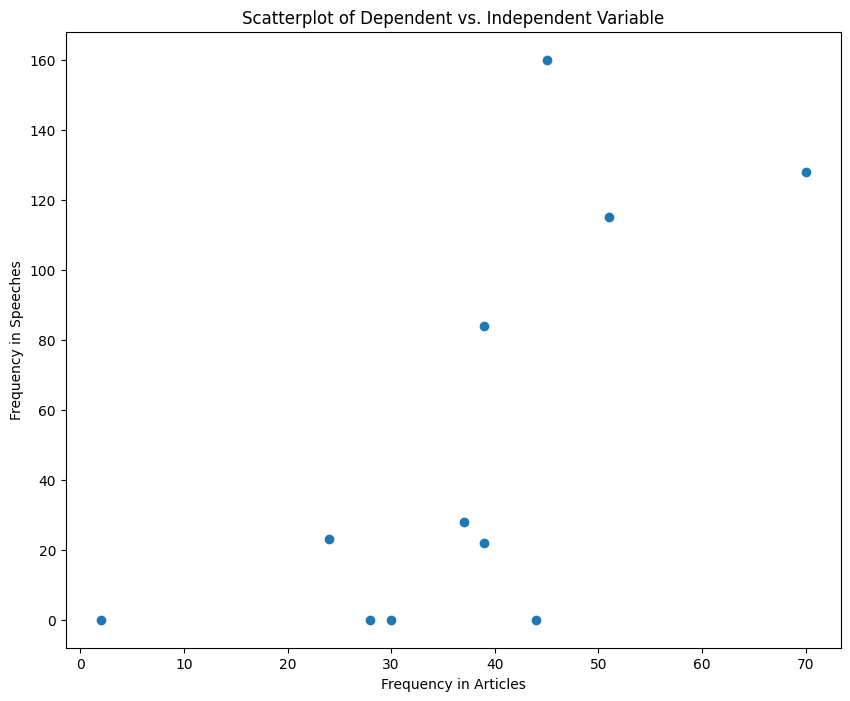

In [44]:
import matplotlib.pyplot as plt

plt.scatter(combined4_df['Frequencynyt'], combined4_df['Frequencyspeech'])
plt.xlabel('Frequency in Articles')
plt.ylabel('Frequency in Speeches')
plt.title('Scatterplot of Dependent vs. Independent Variable')
plt.show()

In [ ]:
import numpy as np
n_iterations = 10000
bootstrap2_diffs = []

# Perform bootstrapping
for _ in range(n_iterations):
    # Resample with replacement
    nyt2_sample = np.random.choice(combined4_df['Frequencynyt'], size=len(combined4_df['Frequencynyt']), replace=True)
    speech2_sample = np.random.choice(combined4_df['Frequencyspeech'], size=len(combined4_df['Frequencyspeech']), replace=True)

    # Calculate the difference in means for the bootstrap samples
    diff_mean = np.mean(nyt2_sample) - np.mean(speech2_sample)
    bootstrap2_diffs.append(diff_mean)

# Convert the list of differences to a numpy array for easier analysis
bootstrap_diffs = np.array(bootstrap2_diffs)

# Calculate the 95% confidence interval
conf2_interval = np.percentile(bootstrap2_diffs, [2.5, 97.5])

# Display the results
print(f"Bootstrap Confidence Interval (95% CI) for the Difference in Means: {conf2_interval}")
print(f"Bootstrap Mean Difference: {np.mean(bootstrap2_diffs)}")

# Check if the confidence interval includes 0 (indicating no significant difference)
if conf2_interval[0] > 0 or conf2_interval[1] < 0:
    print("There is a significant difference between the two distributions.")
else:
    print("There is no significant difference between the two distributions.")

Bootstrap Confidence Interval (95% CI) for the Difference in Means: [-50.81818182  18.91136364]
Bootstrap Mean Difference: -13.965554545454546
There is no significant difference between the two distributions.


# 'Immigration' Frequency Analysis

Total mentions of Immigration: 227
mean    0.112935
std     0.437971
min     0.000000
25%     0.000000
50%     0.000000
75%     0.000000
max     5.000000
Name: immigrants, dtype: float64


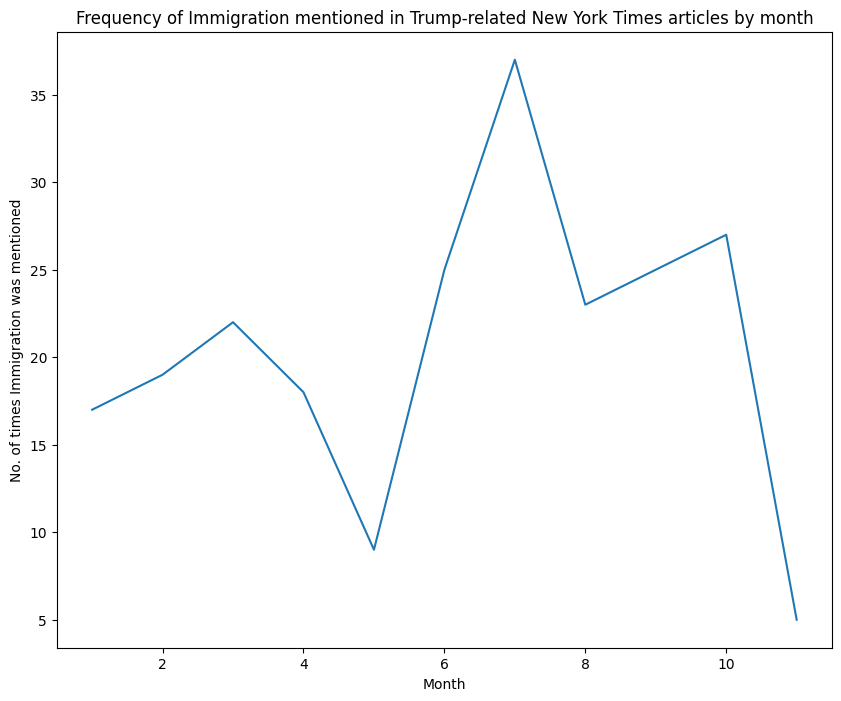

Total mentions of Immigration: 732
mean    18.769231
std      8.170749
min      1.000000
25%     13.500000
50%     19.000000
75%     24.000000
max     36.000000
Name: immigrants, dtype: float64


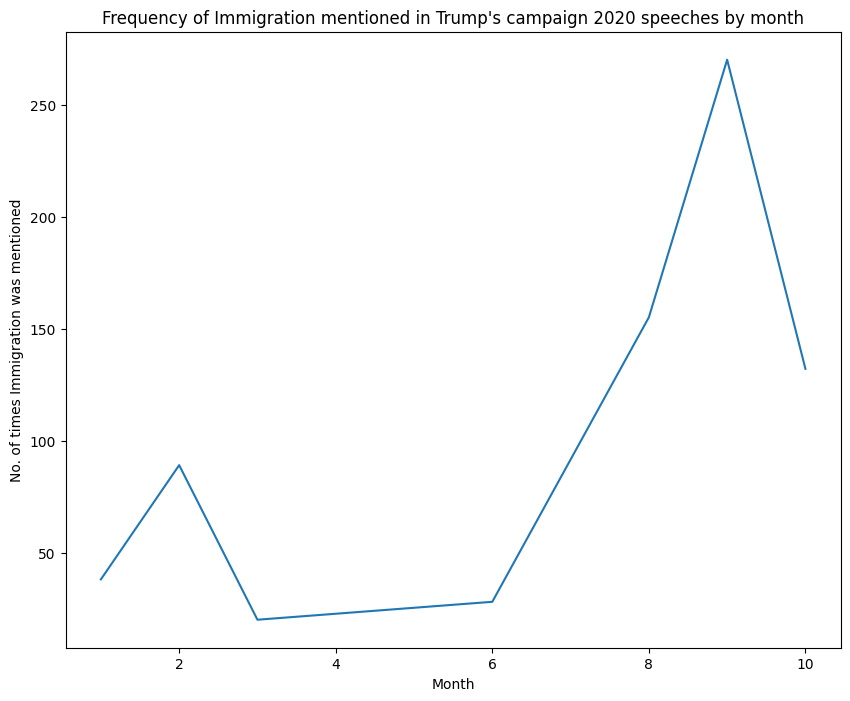

In [40]:
nytimm = count_words(df2, immigration_top10, 'Immigration', 'text', 'Trump-related New York Times articles')
nytimm = nytimm.reset_index()

# Rename the columns for clarity
nytimm.columns = ['Month', 'Frequency']

speechimm = count_words(df, immigration_top10, 'Immigration', 'Speech', "Trump's campaign 2020 speeches")
speechimm = speechimm.reset_index()

# Rename the columns for clarity
speechimm.columns = ['Month', 'Frequency']

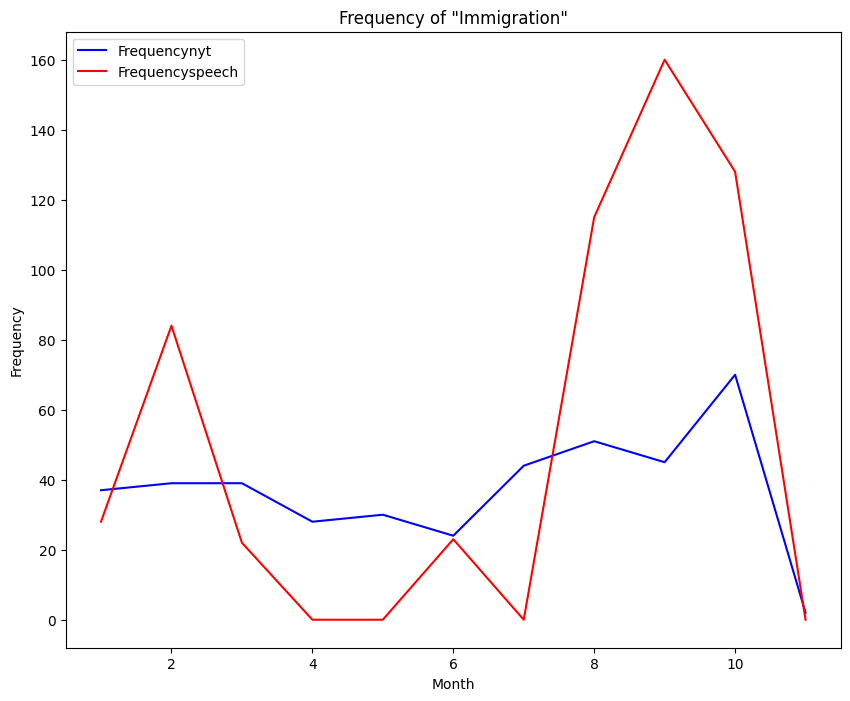

In [47]:
# Combine the two datasets
combined5_df = pd.merge(nytimm, speechimm, on='Month', how='outer', suffixes=('nyt', 'speech'))
combined5_df.fillna(0, inplace=True)
combined5_df.set_index('Month', inplace=True)

combined5_df
plt.plot(combined5_df.index, combined4_df['Frequencynyt'], label='Frequencynyt', color='blue')  # First line with blue color
plt.plot(combined5_df.index, combined4_df['Frequencyspeech'], label='Frequencyspeech', color='red')  # Second line with orange color
plt.legend()
plt.title('Frequency of "Immigration"')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

In [42]:
X = sm.add_constant(combined5_df['Frequencynyt'])
model = sm.OLS(combined5_df['Frequencyspeech'], X).fit()

residuals = model.resid

_, p_shapiro = shapiro(residuals)
print(f"Shapiro-Wilk Test p-value: {p_shapiro:.3f}")

if p_shapiro > 0.05:
    print("Residuals are normally distributed. OLS assumptions are met.")
else:
    print("Residuals are not normally distributed. Consider alternative methods.")

Shapiro-Wilk Test p-value: 0.269
Residuals are normally distributed. OLS assumptions are met.


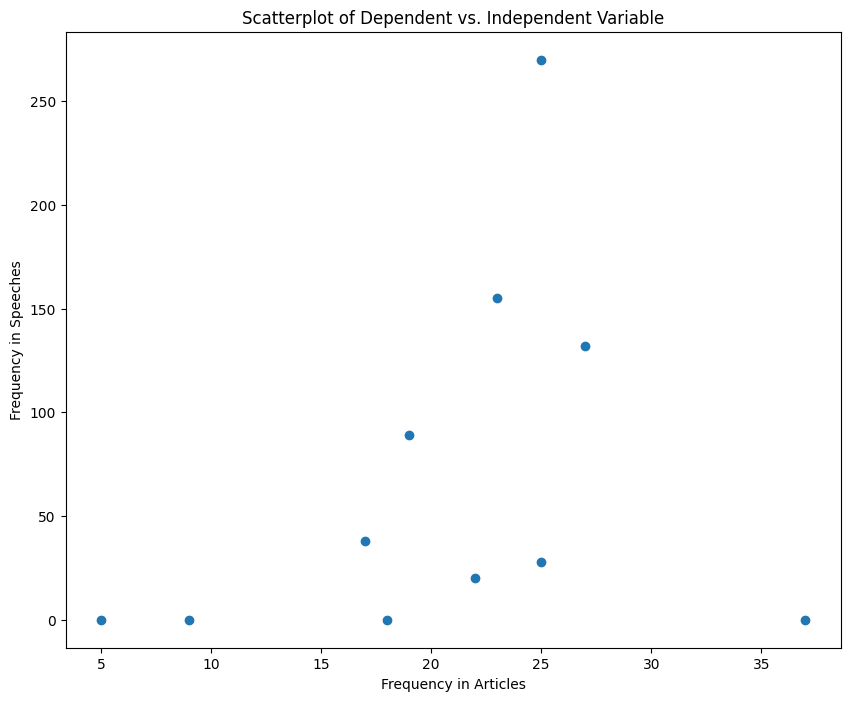

In [45]:
import matplotlib.pyplot as plt

plt.scatter(combined5_df['Frequencynyt'], combined5_df['Frequencyspeech'])
plt.xlabel('Frequency in Articles')
plt.ylabel('Frequency in Speeches')
plt.title('Scatterplot of Dependent vs. Independent Variable')
plt.show()

In [ ]:
import numpy as np
n_iterations = 10000
bootstrap_diffs = []

# Perform bootstrapping
for _ in range(n_iterations):
    # Resample with replacement
    nyt_sample = np.random.choice(combined5_df['Frequencynyt'], size=len(combined5_df['Frequencynyt']), replace=True)
    speech_sample = np.random.choice(combined5_df['Frequencyspeech'], size=len(combined5_df['Frequencyspeech']), replace=True)

    # Calculate the difference in means for the bootstrap samples
    diff_mean = np.mean(nyt_sample) - np.mean(speech_sample)
    bootstrap_diffs.append(diff_mean)

# Convert the list of differences to a numpy array for easier analysis
bootstrap_diffs = np.array(bootstrap_diffs)

# Calculate the 95% confidence interval
conf_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

# Display the results
print(f"Bootstrap Confidence Interval (95% CI) for the Difference in Means: {conf_interval}")
print(f"Bootstrap Mean Difference: {np.mean(bootstrap_diffs)}")

# Check if the confidence interval includes 0 (indicating no significant difference)
if conf_interval[0] > 0 or conf_interval[1] < 0:
    print("There is a significant difference between the two distributions.")
else:
    print("There is no significant difference between the two distributions.")

Bootstrap Confidence Interval (95% CI) for the Difference in Means: [-99.          -2.09090909]
Bootstrap Mean Difference: -45.82152727272727
There is a significant difference between the two distributions.
